In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

В этом ноутбуке предлагается обучить модель классификации изображений датасета CIFAR10, который содержит 60к цветных картинок разрешения 32х32 принадлежащих 10 классам.

Загрузим датасет

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Отрисуем несколько картинок, посмотрим, как выглядит наш датасет



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


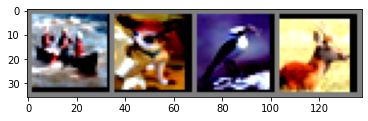

 ship   dog  bird  deer


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Сделаем простую модель на сверточных слоях с несколькими полносвязными слоями в конце.


In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.Tanh()(self.conv1(x)))
        x = self.pool(nn.Tanh()(self.conv2(x)))
        x = nn.Flatten()(x)
        x = nn.Tanh()(self.fc1(x))
        x = nn.Tanh()(self.fc2(x))
        x = nn.Softmax()(self.fc3(x))
        return x




Импортируем дополнительные классы моделей. (https://github.com/soapisnotfat/pytorch-cifar10)

- AlexNet
- GoogleNet

In [4]:
from models import AlexNet


Закинем модель на ГПУ. Выберем в качестве лосс-функции кросс-энтропию. В качестве оптимизатора возьмем Адам.

In [11]:
# net = Net()
net = AlexNet()

net = net.cuda()
criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(net.parameters())
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

epoch = 70

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Обучим модель

In [13]:
for epoch in range(epoch):  

    for X_batch, y_batch in tqdm(trainloader):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        optimizer.zero_grad()

        predictions = net(X_batch)

        loss = criterion(predictions, y_batch)
        loss.backward()

        optimizer.step()


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.61it/s]


Посчитаем точность предсказания на валидационной выборке.

In [14]:
for X_batch, y_batch in testloader:
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    with torch.no_grad():
        predictions = net(X_batch)

    true_lab = y_batch.cpu().numpy()
    _, preds = torch.max(predictions, dim=1)
    # print(true_lab)
    # print(preds)
    print('accuracy_score: ', accuracy_score(true_lab, preds.detach().cpu().numpy()))


accuracy_score:  0.7968


**Наблюдения:**

- Исходная позиция, 2 эпохи, Адам.  - accure = 0.4112
- Исходная позиция, 10 эпох, Адам.  - accure = 0.5623
- Исходная позиция, 6 эпох, Адам.  - accure = 0.583
- Исходная позиция, 6 эпох, sgd(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4), accuracy_score:  0.4564
- Исходная позиция, 10 эпох, sgd(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4), accuracy_score:  0.5086
- Исходная позиция, 20 эпох, sgd(net.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4), accuracy_score:  0.5176
- Исходная позиция, 6 эпох, sgd(net.parameters(), lr=0.1), accuracy_score:  0.25
- 
- AlexNet, 6 эпох, Адам.  - accure = 0.603
- AlexNet, 15 эпох, Адам.  - accure = 0.7412
- Исходная позиция, 15 эпох, sgd(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4), accuracy_score:  0.7564
- Исходная позиция, 20 эпох, sgd(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4), accuracy_score:  0.7605
- Исходная позиция, 50 эпох, sgd(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4), accuracy_score:  0.8111
- Исходная позиция, 70 эпох, sgd(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4), accuracy_score:  0.7968




**Проблема:** Не смогла запустить GoogleNet - выдает ошибку:
RuntimeError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 4.00 GiB total capacity; 2.22 GiB already allocated; 174.20 MiB free; 2.22 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF